In [89]:
import sys
import sql
import pandas as pd
from functools import reduce
from tabulate import tabulate
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import common 

In [109]:
q= 'select * from advisory'
df = pd.DataFrame(sql.execute(q))
len(df)

6956

In [111]:
q= ''' select * from advisory where type = 'Malicious Package' '''
df = pd.DataFrame(sql.execute(q))
len(df)

589

In [113]:
q = '''select *
from advisory a
join package p on a.package_id = p.id
where type != 'Malicious Package'
and ecosystem = 'cocoapods' '''
df = pd.DataFrame(sql.execute(q))
len(df), df['id'].nunique(), df['p.id'].nunique()

(358, 358, 37)

In [90]:
q= '''select distinct advisory_id, p.id as package_id, version
from fixing_releases fr
join advisory a on fr.advisory_id = a.id
join package p on a.package_id = p.id
where ecosystem != 'cocoapods'
and type != 'Malicious Package'
and version != %s;'''
df = pd.DataFrame(sql.execute(q, (common.manualcheckup,)))
len(df), df['advisory_id'].nunique()

(7083, 4776)

In [117]:
q= '''select distinct advisory_id
from advisory a
join fixing_releases fr on a.id = fr.advisory_id
join package p on a.package_id = p.id
and ecosystem != 'cocoapods'
and version = 'manual checkup needed'
and advisory_id not in
(select distinct advisory_id
from advisory a
join fixing_releases fr on a.id = fr.advisory_id
join package p on a.package_id = p.id
and ecosystem != 'cocoapods'
and version != 'manual checkup needed')'''
df = pd.DataFrame(sql.execute(q))
df['advisory_id'].nunique()

102

In [115]:
q = '''select *
from advisory a
join package p on a.package_id = p.id
where type != 'Malicious Package'
and ecosystem != 'cocoapods'
and a.id not in
(select advisory_id from fixing_releases)'''
df = pd.DataFrame(sql.execute(q))
len(df), df['id'].nunique()

(1131, 1131)

In [94]:
q= '''select distinct advisory_id, p.id as package_id, version
from fixing_releases fr
join advisory a on fr.advisory_id = a.id
join package p on a.package_id = p.id
where ecosystem != 'cocoapods'
and type != 'Malicious Package'
and version != %s
and repository_url = %s'''
df = pd.DataFrame(sql.execute(q, (common.manualcheckup,common.norepo)))
len(df), df['package_id'].nunique(), df['advisory_id'].nunique()

(518, 300, 399)

In [95]:
q='''select t1.ecosystem as ecosystem, advisories, advisory_with_CVEs, packages, fixing_releases
from
(select ecosystem, count(distinct a.id) as advisories, count(distinct p.id) as packages, count(distinct advisory_id, version) as fixing_releases
from advisory a
join package p on a.package_id = p.id
join fixing_releases fr on a.id = fr.advisory_id
where type != 'Malicious Package'
and version != 'manual checkup needed'
and ecosystem != 'cocoapods'
and repository_url != 'no repository listed'
group by ecosystem) as t1
join
(select ecosystem, count(distinct a.id) as advisory_with_CVEs
from advisoryCVE aC
join advisory a on aC.advisory_id = a.id
join fixing_releases fr on a.id = fr.advisory_id
join package p on a.package_id = p.id
where type != 'Malicious Package'
and version != 'manual checkup needed'
and ecosystem != 'cocoapods'
and repository_url != 'no repository listed'
group by ecosystem) as t2
on t1.ecosystem = t2.ecosystem
order by advisories desc;'''
df = pd.DataFrame(sql.execute(q))

In [96]:
df

,ecosystem,advisories,advisory_with_CVEs,packages,fixing_releases
0,Maven,1374,1132,694,1950
1,Composer,855,599,228,1733
2,npm,792,474,540,949
3,pip,567,404,269,834
4,NuGet,333,277,92,410
5,Go,235,190,183,325
6,RubyGems,221,168,121,364


In [97]:
q = '''select ecosystem, ac.cwe as cwe
from advisory a
join package p on a.package_id = p.id
join fixing_releases fr on a.id = fr.advisory_id
join advisoryCWE aC on a.id = aC.advisory_id
where type != 'Malicious Package'
and version != 'manual checkup needed'
and ecosystem != 'cocoapods'
and repository_url != 'no repository listed';'''
cwe = pd.DataFrame(sql.execute(q))
total_cwes = cwe['cwe'].nunique()
cwe = cwe.groupby('ecosystem')[['cwe']].nunique()
cwe


,cwe
ecosystem,
Composer,68
Go,50
Maven,112
NuGet,34
RubyGems,47
npm,82
pip,84


In [98]:
df=reduce(lambda x,y : pd.merge(x,y,on='ecosystem'),[df, cwe])
df.reset_index()
df

,ecosystem,advisories,advisory_with_CVEs,packages,fixing_releases,cwe
0,Maven,1374,1132,694,1950,112
1,Composer,855,599,228,1733,68
2,npm,792,474,540,949,82
3,pip,567,404,269,834,84
4,NuGet,333,277,92,410,34
5,Go,235,190,183,325,50
6,RubyGems,221,168,121,364,47


In [99]:
df.loc[len(df)]=['Total',df['advisories'].sum(),df['advisory_with_CVEs'].sum(),df['packages'].sum(), df['fixing_releases'].sum(), total_cwes] 
table = df

In [100]:
q = '''select distinct a.id, p.ecosystem, a.severity
from advisory a
join package p on a.package_id = p.id
join fixing_releases fr on a.id = fr.advisory_id
join advisoryCWE aC on a.id = aC.advisory_id
where type != 'Malicious Package'
and version != 'manual checkup needed'
and ecosystem != 'cocoapods'
and repository_url != 'no repository listed';'''
sev = pd.DataFrame(sql.execute(q))
l, m, h = sev[sev['severity']=='L'],sev[sev['severity']=='M'],sev[sev['severity']=='H']
eco_l = l.groupby('ecosystem')[['severity']].count()
eco_l = eco_l.rename(columns={'severity':'L'})
eco_m = m.groupby('ecosystem')[['severity']].count()
eco_m = eco_m.rename(columns={'severity':'M'})
eco_h = h.groupby('ecosystem')[['severity']].count()
eco_h = eco_h.rename(columns={'severity':'H'})
sf=reduce(lambda x,y : pd.merge(x,y,on='ecosystem'),[eco_l, eco_m, eco_h])
sf = sf.reset_index()
l,m,h = len(l), len(m), len(h)
sf.loc[len(df)] = ['Total',l,m,h]
sf['T'] = sf.L + sf.M + sf.H
sf['L'] = round(sf['L'] / sf['T'],2)
sf['M'] = round(sf['M'] / sf['T'],2)
sf['H'] = round(sf['H'] / sf['T'],2)
sf['severity'] = sf[['L','M','H']].apply(tuple, axis=1)
sf = sf.drop(['L','M','H','T'], axis=1)
sf

,ecosystem,severity
0,Composer,"(0.04, 0.53, 0.43)"
1,Go,"(0.06, 0.54, 0.4)"
2,Maven,"(0.05, 0.54, 0.41)"
3,NuGet,"(0.02, 0.33, 0.66)"
4,RubyGems,"(0.03, 0.59, 0.38)"
5,npm,"(0.05, 0.47, 0.48)"
6,pip,"(0.06, 0.62, 0.32)"
8,Total,"(0.05, 0.52, 0.43)"


In [101]:
df = reduce(lambda x,y : pd.merge(x,y,on='ecosystem'),[table, sf])
df

,ecosystem,advisories,advisory_with_CVEs,packages,fixing_releases,cwe,severity
0,Maven,1374,1132,694,1950,112,"(0.05, 0.54, 0.41)"
1,Composer,855,599,228,1733,68,"(0.04, 0.53, 0.43)"
2,npm,792,474,540,949,82,"(0.05, 0.47, 0.48)"
3,pip,567,404,269,834,84,"(0.06, 0.62, 0.32)"
4,NuGet,333,277,92,410,34,"(0.02, 0.33, 0.66)"
5,Go,235,190,183,325,50,"(0.06, 0.54, 0.4)"
6,RubyGems,221,168,121,364,47,"(0.03, 0.59, 0.38)"
7,Total,4377,3244,2127,6565,172,"(0.05, 0.52, 0.43)"


In [102]:
df['non-CVEs (%)'] = df['advisories'] - df['advisory_with_CVEs']
df['non-CVEs (%)'] = round (df['non-CVEs (%)'] / df['advisories'] * 100 , 2)
df

,ecosystem,advisories,advisory_with_CVEs,packages,fixing_releases,cwe,severity,non-CVEs (%)
0,Maven,1374,1132,694,1950,112,"(0.05, 0.54, 0.41)",17.61
1,Composer,855,599,228,1733,68,"(0.04, 0.53, 0.43)",29.94
2,npm,792,474,540,949,82,"(0.05, 0.47, 0.48)",40.15
3,pip,567,404,269,834,84,"(0.06, 0.62, 0.32)",28.75
4,NuGet,333,277,92,410,34,"(0.02, 0.33, 0.66)",16.82
5,Go,235,190,183,325,50,"(0.06, 0.54, 0.4)",19.15
6,RubyGems,221,168,121,364,47,"(0.03, 0.59, 0.38)",23.98
7,Total,4377,3244,2127,6565,172,"(0.05, 0.52, 0.43)",25.89


In [103]:
print(tabulate(df, tablefmt='latex', headers='keys',showindex=False))

\begin{tabular}{lrrrrrlr}
\hline
 ecosystem   &   advisories &   advisory\_with\_CVEs &   packages &   fixing\_releases &   cwe & severity           &   non-CVEs (\%) \\
\hline
 Maven       &         1374 &                 1132 &        694 &              1950 &   112 & (0.05, 0.54, 0.41) &          17.61 \\
 Composer    &          855 &                  599 &        228 &              1733 &    68 & (0.04, 0.53, 0.43) &          29.94 \\
 npm         &          792 &                  474 &        540 &               949 &    82 & (0.05, 0.47, 0.48) &          40.15 \\
 pip         &          567 &                  404 &        269 &               834 &    84 & (0.06, 0.62, 0.32) &          28.75 \\
 NuGet       &          333 &                  277 &         92 &               410 &    34 & (0.02, 0.33, 0.66) &          16.82 \\
 Go          &          235 &                  190 &        183 &               325 &    50 & (0.06, 0.54, 0.4)  &          19.15 \\
 RubyGems    &          2

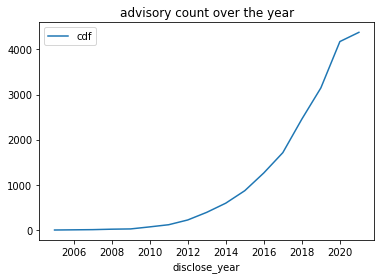

In [104]:
q= '''select year(a.disclose_date) as disclose_year, count(distinct a.id) as count
from advisory a
join package p on a.package_id = p.id
join fixing_releases fr on a.id = fr.advisory_id
where type != 'Malicious Package'
and version != 'manual checkup needed'
and ecosystem != 'cocoapods'
and repository_url != 'no repository listed'
group by year(a.disclose_date);'''
df = pd.DataFrame(sql.execute(q))
df['cdf']=df['count'].cumsum()
fig = df.plot(x='disclose_year',y='cdf',kind='line', title = 'advisory count over the year').get_figure()

In [105]:
fig.savefig('cdf_disclose.png')


In [106]:
df

,disclose_year,count,cdf
0,2005,2,2
1,2006,4,6
2,2007,4,10
3,2008,10,20
4,2009,6,26
5,2010,45,71
6,2011,48,119
7,2012,105,224
8,2013,169,393
9,2014,203,596


In [107]:
(4300 - 864) / 4300

0.7990697674418604

In [108]:
4300 - 864

3436